# Quit while you're ahead:  a surprising interaction between game performance and motivation

## Introduction

Online games provide an opportunity to study skill acquisition in naturalistic settings with high statistical power. We use data from [Axon](http://axon.wellcomeapps.com/), a simple online game, to investigate how patterns in skill acquisition relate to players’ decisions to remain engaged with the game. Exploring a sample of more than 380 thousand players we observe that exceptional performance is associated with an increased rate of drop-out. This finding is in apparent contradiction to a simple behaviourist account in which the rewards (of success in the game) reinforce the behaviour (of continuing to play).

This notebook takes you from the raw data, which are publically available, through to an initial visualiation of the basic phenomenon, and then to statistical models which confirm that it is specifically scores which are high with respect to a players' personal past performance (i.e. their personal bests), not just scores which are high or occur later in the game, which predict quitting. The analysis shows the benefit of incorporating simple perspectives on the psychological states of players into analysis of game performance and retention data.

### Credits

An Erasmus+ Traineeship completed by Dagmar Adamcova at the University of Sheffield (supervised by Tom Stafford).


## Code

This is a jupyter notebok which uses Python for data management, visualisation and statistical models. Code blocks (such as the one immediately below) and output are shown, as well as explanatory commmentary such as this.

In [1]:
# load the libraries we'll use
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## Data
The [data set](https://osf.io/xsb6g/) we use, extracted by Stafford and Haasnoot (2017), consists of more than 1.2 million players. We restrict our analysis to a subset of players who played between 3 and 200 games. Players with missing values and null scores were removed in preprocessing. 

As a result of reaching certain milestones in the game some players tend to repeatedly earn the same score (see output for most frequent scores below). We exclude players who achieved any of the five most frequent scores more than once as these would bias our analysis later on.

In [2]:
# load data (run calc_ratio.ipynb first to generate the data file used in this notebook)
df = pd.read_csv('data/outdf.csv', usecols=['id', 'attempt', 'score', 'quit', 'ratio']) 

### Data cleaning

In [3]:
# show most common scores in the data --- there are many games which end in very low scores
df['score'].value_counts().head(10) # score x frequency

176.0    263484
450.0     17235
181.0     16348
351.0     13180
352.0      1764
362.0       331
314.0       303
242.0       293
307.0       287
309.0       287
Name: score, dtype: int64

In [4]:
# MASK PLAYERS WHO SCORED 176, 450, 181, 351, or 352 MORE THAN ONCE

scores = [176.0, 450.0, 181.0, 351.0, 352.0]
ids = pd.DataFrame(df['id'].unique(), columns=['id']) # returns a data frame containing all unique IDs

for i in scores:
    counts = df[df.score==i].groupby('id')['attempt'].count().reset_index()
    counts_filtered = counts.drop(counts[(counts.attempt < 2)].index)
    ids.drop(ids[ids.id.isin(counts_filtered.id)].index, inplace=True)

mask = df['id'].isin(ids.id)

In [5]:
# mask players with attempt > 200 (117 players)

attempts200 = df[mask][df[mask].attempt > 200]['id'].unique() # unique IDs of players with attempt > 200 
ids.drop(ids[ids.id.isin(attempts200)].index, inplace=True) # drop IDs
mask = df['id'].isin(ids.id) # update mask

In [6]:
df_masked = df[mask] # apply mask

In [7]:
print('N OF PLAYERS BEFORE MASKING: ', df.groupby('id').ngroups)
print('N OF PLAYERS AFTER MASKING: ', df[mask].groupby('id').ngroups)
print('DF SHAPE: ', df[mask].shape) # rows x columns

N OF PLAYERS BEFORE MASKING:  460435
N OF PLAYERS AFTER MASKING:  384717
DF SHAPE:  (2350574, 5)


### The cleaned data

In [8]:
# show the data
df[mask].head(3)
# each row contains 
# - players id,
# - attempt number, 
# - score, 
# - if they quit or not, 
# - the ratio of that score to previous best score

,id,attempt,score,quit,ratio
0,00000B33-063F-D16F-4196-4BDB512FC224,1,18336.0,0,NaN
1,00000B33-063F-D16F-4196-4BDB512FC224,2,38977.0,0,2.125709
2,00000B33-063F-D16F-4196-4BDB512FC224,3,34075.0,0,0.874234


In [9]:
df[mask].groupby('id')['attempt'].max().describe() # max attempts

count    384717.000000
mean          6.591209
std           9.236221
min           3.000000
25%           3.000000
50%           4.000000
75%           6.000000
max         200.000000
Name: attempt, dtype: float64

The filtered data set comprises 384,717 players and 2,350,574 individual gameplay events. Note that even though we include players who played up to 200 games, 75% of players did not play more than six times.

## Analysis

### Subgroup learning curves

As we group players according to the number of games they played and plot their learning curves we observe an increase in mean score on their last attempt. This trend is especially prominent in less experienced players (i.e. those who played up to approx. 50 games).

In [10]:
maxgame = df_masked.groupby('id')['attempt'].max().reset_index() # find max attempt for each player  

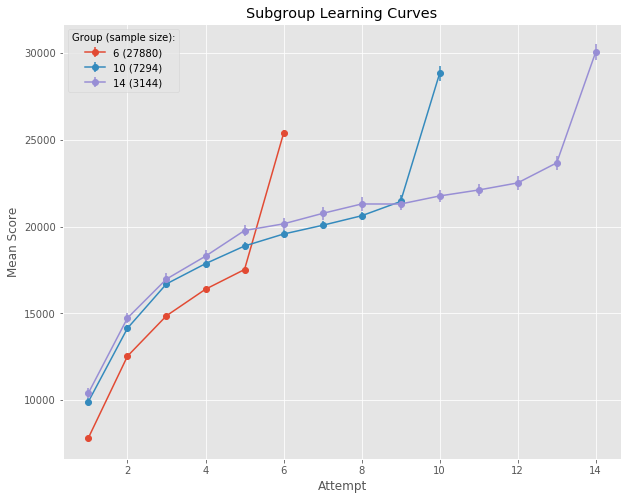

In [11]:
plt.figure(figsize=(10, 8)) # set figure size
plt.rc("font", size=10) # set font size

curves = [6, 10, 14] # >> CHANGE VALUES TO PLOT FOR DIFFERENT GROUPS <<

for i in curves:
    subgroup_ids = maxgame.drop(maxgame[~(maxgame.attempt == i)].index) # retain players who played exactly i games and drop the rest  
    subgroup_mask = df_masked['id'].isin(subgroup_ids.id)
    
    means = df_masked[subgroup_mask].groupby('attempt', as_index=False)['score'].mean() # calculate mean score for each attempt
    se = df_masked[subgroup_mask].groupby('attempt')['score'].sem() # standard error
    n = len(subgroup_ids) # sample size
    
    plt.errorbar(means['attempt'], means['score'], yerr=se, fmt='-o', label=str(i) + ' (' + str(n) + ')') # plot curve
    plt.xlabel('Attempt')
    plt.ylabel('Mean Score')
    plt.title('Subgroup Learning Curves')
    plt.legend(title='Group (sample size):')

This increase in score is unusual as it contrasts with the traditional shape of the learning curve and suggests exceptional performance and player drop out may be related.


### Missing values

Remove missing values (score ratios for players’ first attempts, which could not be calculated).

In [12]:
print('MISSING VALUES: ')
print(df_masked.isnull().sum()) # missing ratios for first attempts

MISSING VALUES: 
id              0
attempt         0
score           0
quit            0
ratio      384717
dtype: int64


In [13]:
# DROP ROWS WITH NaNs

df_masked.dropna(how='any', inplace=True) # does not reset index

## Score ratio

Given the observation of exceptional scores on players’ last attempts we ask whether drop out can be predicted from players’ past performance, specifically from the relative difference between their last score and previous high score. 

In order to quantify this relationship between scores we devise a simple metric, the score ratio, computed as the ratio of players’ current score to their previous high score. 

Ratio computation was done in preprocessing (code included in calc_ratio.ipynb).

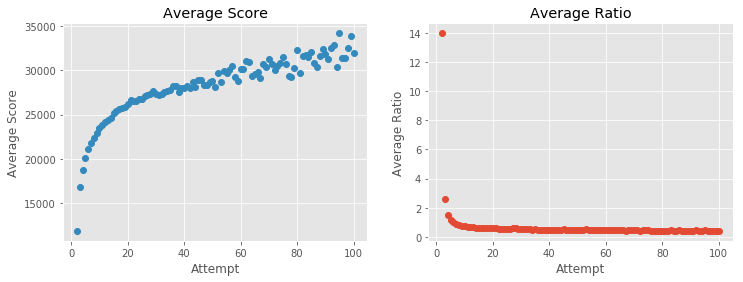

In [14]:
# AVERAGE SCORE & AVERAGE RATIO OVER TIME

plt.figure(figsize=(12, 4)) # set figure size
plt.rc("font", size=10) # set font size

# plot average score

avg_score = df_masked.groupby('attempt', as_index=False)['score'].mean()
avg_score.drop(avg_score[avg_score.attempt > 100].index, inplace=True) # retain values for the first 100 attempts only

plt.subplot(121)
plt.errorbar(avg_score['attempt'], avg_score['score'], fmt='o', color='C1')
plt.xlabel('Attempt')
plt.ylabel('Average Score')
plt.title('Average Score')

# plot average ratio

avg_ratio = df_masked.groupby('attempt', as_index=False)['ratio'].mean()
avg_ratio.drop(avg_ratio[avg_ratio.attempt > 100].index, inplace=True) # retain values for the first 100 attempts only

plt.subplot(122)
plt.errorbar(avg_ratio['attempt'], avg_ratio['ratio'], fmt='o', color='C0') 
plt.xlabel('Attempt')
plt.ylabel('Average Ratio')
plt.title('Average Ratio')

Note that unlike score, which increases with practice, score ratio rapidly decreases and plateaus within the first few attempts.

### Score ratio and quitting: higher quit rates for personal bests

The relative frequency of quitting appears to be higher for attempts with score ratios larger than two.

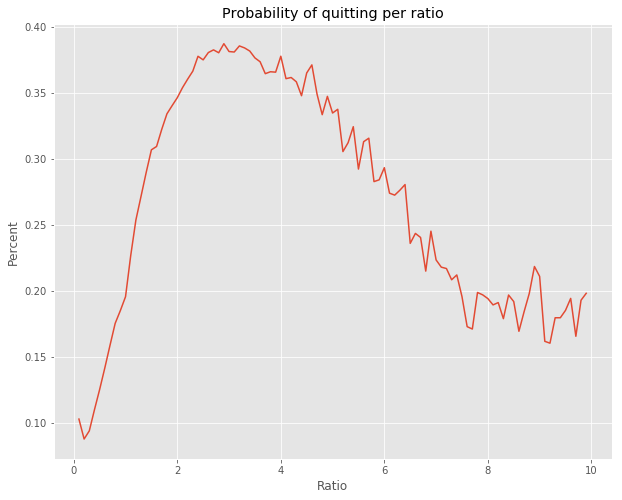

In [15]:
# PROBABILITY OF QUITTING PER RATIO

bins = np.arange(0.0, 10.0, 0.1) # specify bin range and width
df_masked['binnum'] = np.digitize(df_masked['ratio'], bins) # apply bins

# calc probability per bin

def calc_p(x):
    return (x.quit[x.quit==1].count() / x.quit.count())

prob = df_masked.groupby('binnum').apply(calc_p)

prob_df = pd.DataFrame(prob, columns=['probability']) # new data frame for plotting
prob_df['ratio'] = np.nan
prob_df['ratio'].update(pd.Series(bins))

# plot

plt.figure(figsize=(10, 8)) # set figure size
plt.rc("font", size=10) # set font size

plt.errorbar(prob_df['ratio'], prob_df['probability'], fmt='-', color='C0')
plt.xlabel('Ratio')
plt.ylabel('Percent')
plt.title('Probability of quitting per ratio')

### Quitting and score ratio: Players final games are more likely to be personal bests

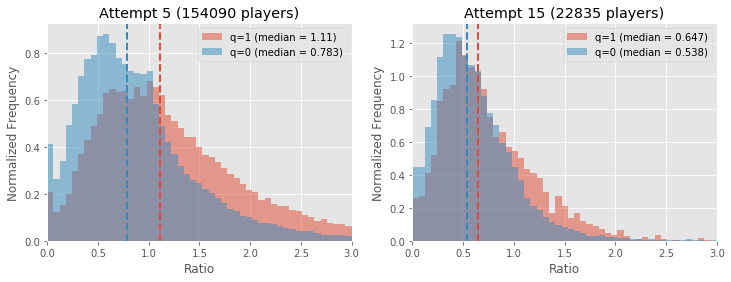

In [16]:
# NORMALIZED HISTOGRAM FOR Q=1 & Q=0

plt.figure(figsize=(12, 4)) # set figure size
plt.rc('font', size=10) # set font size

attempt_num = {121:5, 122:15} # >> CHANGE VALUES TO PLOT FOR DIFFERENT ATTEMPTS <<

for key, value in attempt_num.items():
    median_q1 = df_masked[(df_masked.attempt == value) & (df_masked.quit==1)].ratio.median() # median for q=1
    median_q0 = df_masked[(df_masked.attempt == value) & (df_masked.quit==0)].ratio.median() # median for q=0

    bins3 = np.linspace(0, 3.0, 50)
    
    plt.subplot(key)
    plt.hist(df_masked[(df_masked.attempt == value) & (df_masked.quit==1)].ratio, bins3, normed=1, alpha=0.5, label='q=1 (median = ' + str(round(median_q1, 3)) + ')')
    plt.hist(df_masked[(df_masked.attempt == value) & (df_masked.quit==0)].ratio, bins3, normed=1, alpha=0.5, label='q=0 (median = ' + str(round(median_q0, 3)) + ')')
    plt.xlim([0, 3])
    plt.xlabel('Ratio')
    plt.ylabel('Normalized Frequency')
    plt.legend()

    plt.axvline(median_q1, color='C0', linestyle='dashed', linewidth=2) # draw dashed lines for medians
    plt.axvline(median_q0, color='C1', linestyle='dashed', linewidth=2)
    plt.title('Attempt ' + str(value) + ' (' + str(len(df_masked[df_masked.attempt == value].ratio)) + ' players)')

Plotting the distributions of quitting (q = 1) and non-quitting (q = 0) games within the same attempt against each other allows us to visualize the shift in median ratio. 

Players who drop out after nth attempt experience larger relative improvements in performance on said attempt compared to players who continue playing.

## Regression model: scoring a personal best predicts quitting above and beyond other factors

Following our aim to test whether drop out can be predicted we fit a logistic regression model. 

### Data preparation

As we saw earlier differences in mean ratio within the first few attempts are substantial. For this reason we exclude attempts lower than five from our analysis. 

In [17]:
# We are using scikit-learn for regression models. You may need to install using, e.g., install scikit-learn.  
from sklearn.utils import resample
from patsy import dmatrices
from sklearn.cross_validation import train_test_split

/usr/local/anaconda3/envs/sheffield/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
df_masked_2 = df_masked.drop(df_masked[(df_masked.attempt < 5)].index) 

We correct for class imbalance by downsampling the majority class.

In [19]:
# DOWNSAMPLE MAJORITY CLASS

majority_downsampled = resample(df_masked_2[df_masked_2.quit==0], replace=False, 
                n_samples=len(df_masked_2[df_masked_2.quit==1]), random_state=123)

resampled = pd.concat([majority_downsampled, df_masked_2[df_masked_2.quit==1]])

In [20]:
# PREPARE DATA FOR LOGISTIC REGRESSION

y, X = dmatrices('quit ~ attempt + ratio', resampled, return_type="dataframe")
y = np.ravel(y) # convert y into a numpy ndarray

And finally we split our data into a training and testing set (70% and 30% respectively).

In [21]:
# SPLIT INTO TRAIN & TEST SETS

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Model

We fit a logistic regression model with attempt number and ratio as predictor variables. 

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
import scikitplot as skplt # you may need to install with, e.g., pip install scikit-plot

In [23]:
# FIT LOG REG MODEL

model = LogisticRegression()
model.fit(X_train, y_train)
print('ACCURACY SCORE: ', model.score(X_test, y_test)) # accuracy score

ACCURACY SCORE:  0.647617602428


In [24]:
# CROSS-VALIDATION 

scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=10) 
print(scores.mean()) # print mean accuracy score

0.649520940307


The model performs at 64% accuracy (as supported by 10-fold cross-validation).

In [25]:
# ODDS RATIOS

pd.DataFrame(list(zip(X.columns, np.transpose(np.exp(model.coef_)))), columns=['Predictor', 'Odds Ratio'])

,Predictor,Odds Ratio
0,Intercept,[1.0153374533]
1,attempt,[0.969133820349]
2,ratio,[1.6474372825]


Odds ratios suggest that the likelihood of quitting increases with score ratio and decreases with attempt number.

In [26]:
print(y_test.mean()) # proportion of quit=1 in dataset
print(model.predict(X_test).mean()) # proportion of predicted quit=1 

0.496732422863
0.57751138088


The model tends to overpredict the positive class.

In [27]:
# AUC

model_predicted = model.predict_proba(X_test)

fpr, tpr, _ = metrics.roc_curve(y_test, model_predicted[:, 1]) # ROC
auc = metrics.auc(fpr,tpr) # AUC
print("AUC: ", auc) 

AUC:  0.708484650259


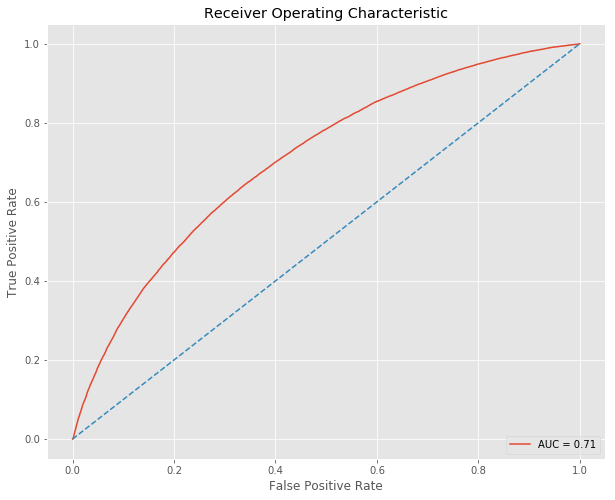

In [28]:
# plot ROC

plt.figure(figsize=(10, 8)) # set figure size
plt.rc('font', size=10) # set font size

plt.plot(fpr, tpr, 'C0', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'C1--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic')

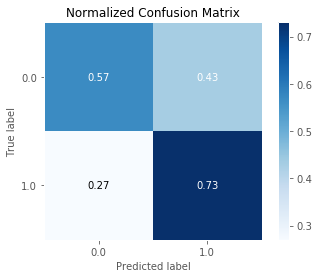

In [29]:
# CONFUSION MATRIX

# true negatives, false positives
# false negatives, true positives

skplt.metrics.plot_confusion_matrix(y_test, model.predict(X_test), normalize=True)

The model correctly classifies up to 73% of the positive class.

## Conclusion

Early drop out in games such as Axon may, in part, be related to players’ performance. We’ve demonstrated how quitting can be predicted given information about players’ relative performance history. With only two features we’re able to predict drop out with 64% accuracy. Future research may investigate how this effect generalizes to other games.

## References

Stafford, T., & Haasnoot, E. (2017). Testing Sleep Consolidation in Skill Learning: A Field Study Using an Online Game. Topics in Cognitive Science, 9(2), 485–496. https://doi.org/10.1111/tops.12232


## Authors

Tom Stafford  
t.stafford@sheffield.ac.uk

Dagmar Adamcova  
dagmar.adamcova@mail.muni.cz